In [1]:
import numpy as np

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt

import reciprocalspaceship as rs
import gemmi

import masks

In [2]:
def latex_float(f):
    float_str = "{0:.2e}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

## data loading

In [3]:
# parameters

PDB = '/Users/tjlane/Desktop/PL-workshop/DEDs-svd/Super_dark_swissFEL_refine_33.pdb'

LOW_RES =   2.0
HIGH_RES = 32.0

#MASK = lambda map : map  ; MASK_NAME = 'none'
#MASK = lambda map : masks.mask_solvent(PDB, map)  ; MASK_NAME = 'solvent'
#MASK = masks.TT_chainA_region_only  ; MASK_NAME = 'TT_region'
MASK = masks.FDA_chainA_region_only  ; MASK_NAME = 'FAD_region'
#MASK = masks.FDA_and_TT_chainA_region_only  ; MASK_NAME = 'TT+FAD_region'

STANDARDIZE = False # set map to zero mean, 1 std

In [4]:
!ls /Users/tjlane/Desktop/PL-workshop/DEDs-svd/

ded-mtzs              pml-scripts           svd_components
figures               superdark_deposit.pdb


In [5]:
base_path = '/Users/tjlane/Desktop/PL-workshop/DEDs-svd/'

timepoints = {
         3.0 : 'ded-mtzs/2p0_3ps_light_staraniso-merged-aniso_mkFoFo.mtz',
       300.0 : 'ded-mtzs/2p0_300ps_light_staraniso_correct-merged-aniso_mkFoFo.mtz',
      1000.0 : 'ded-mtzs/2p0_1ns_light_staraniso_1molASU_mkFoFo.mtz',
      3000.0 : 'ded-mtzs/2p0_3ns_LIGHT_1asu_staraniso-merged-aniso_mkFoFo.mtz',
     10000.0 : 'ded-mtzs/10ns_v6_mkFoFo.mtz',
     30000.0 : 'ded-mtzs/2p0_30ns_light_staraniso-merged-aniso_mkFoFo.mtz',
   1000000.0 : 'ded-mtzs/2p0_1us_light_staraniso-merged-aniso_mkFoFo.mtz',
  10000000.0 : 'ded-mtzs/2p0_10us_LIGHT_staraniso-merged-aniso_mkFoFo.mtz',
  30000000.0 : 'ded-mtzs/2p0_30us_light_staraniso-merged-aniso_mkFoFo.mtz',
 100000000.0 : 'ded-mtzs/2p0_100us_LIGHT_staraniso-merged-aniso_mkFoFo.mtz',
}

for k in timepoints.keys():
    timepoints[k] = base_path + timepoints[k]

In [6]:
def cut_res(df, h_res, l_res):
    ds.compute_dHKL(inplace=True)
    df = df.loc[(df['dHKL'] >= h_res) & (df['dHKL'] <= l_res)]
    return df

def standardize_map(map):
    return (map - map.mean()) / map.std()

In [7]:
# load all Fs and sigFs into one big rs table
tps = sorted(timepoints.keys())
maps = []

for tp in tps:

    ds = rs.read_mtz(timepoints[tp]) 
    ds.compute_dHKL(inplace=True)

    ds = cut_res(ds, LOW_RES, HIGH_RES)

    gemmi_mtz = ds.to_gemmi()
    grid = gemmi_mtz.transform_f_phi_to_map('KFOFOWT', 'PHIKFOFOWT', exact_size=(180, 300, 432))

    map = np.array( MASK( grid ) )
    if STANDARDIZE:
        map = standardize_map(map)
    
    MAP_SHAPE = map.shape
    maps.append(map.flatten())

    fraction_of_zeros = np.sum(map == 0) / float(np.product(map.shape))
    print( MAP_SHAPE, np.min(ds['dHKL']), np.max(ds['dHKL']), fraction_of_zeros)

maps = np.array(maps)
print(maps.shape)

(180, 300, 432) 2.163017 31.289146 0.9967378257887517
(180, 300, 432) 2.1956654 30.97964 0.9967378257887517
(180, 300, 432) 2.2747512 31.289146 0.9967378257887517
(180, 300, 432) 2.3459172 31.289146 0.9967378257887517
(180, 300, 432) 2.3633437 31.289146 0.9967378257887517
(180, 300, 432) 2.390934 31.289146 0.9967378257887517
(180, 300, 432) 2.2414005 31.289146 0.9967378257887517
(180, 300, 432) 2.1829526 31.289146 0.9967378257887517
(180, 300, 432) 2.2473514 31.289146 0.9967378257887517
(180, 300, 432) 2.2547371 30.97964 0.9967378257887517
(10, 23328000)


## and try SVD

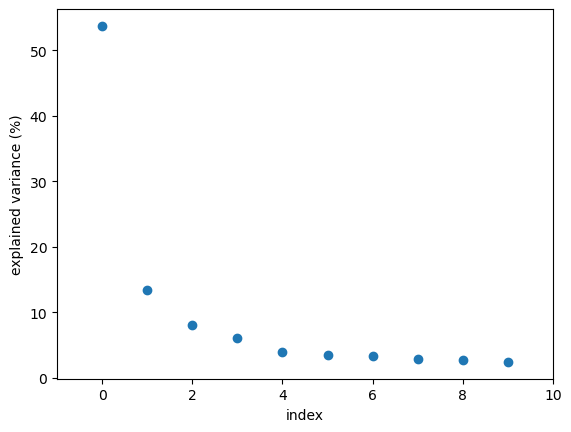

In [8]:
U, S, Vh = np.linalg.svd(maps, full_matrices=False)

explained_variance = np.square(S) / np.sum(np.square(S)) * 100.0

plt.figure()
plt.plot(explained_variance, 'o')
plt.xlabel('index')
plt.ylabel('explained variance (%)')
plt.xlim([-1, 10])
plt.show()

(180, 300, 432) (10, 10) (10, 23328000)


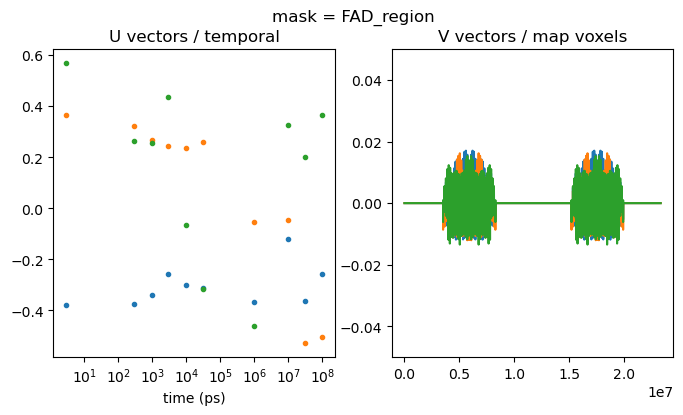

In [9]:
n = 3 # number of components to plot

print(map.shape, U.shape, Vh.shape)

plt.figure(figsize=(8,4))
plt.suptitle(f'mask = {MASK_NAME}')

axL = plt.subplot(121)
axL.plot(np.array(tps), U[:,:n] + 0.07 * np.arange(n)[None,:], '.')

plt.title('U vectors / temporal')
plt.xlabel('time (ps)')
plt.xscale('symlog')

#plt.ylim([-0.2, 0.4])
#plt.xlim([1000,1.5e6])

axR = plt.subplot(122)
axR.plot(Vh[:n,:].T)
plt.title('V vectors / map voxels')
plt.ylim([-0.05, 0.05])

plt.show()

[-0.10596201  0.00087354 -0.28302986]
[ 6.45922962e-01  7.42162573e-07 -4.30528916e-01]


/var/folders/s9/bht_sc9n7ys6m0q3h_3htntc0000gn/T/ipykernel_33056/994547784.py:14: RuntimeWarning: overflow encountered in exp
  expntl = lambda t,a,b,c: a * np.exp(-b*t) + c


[ 4.23805664e-01  2.04399629e-04 -1.28454618e-01]


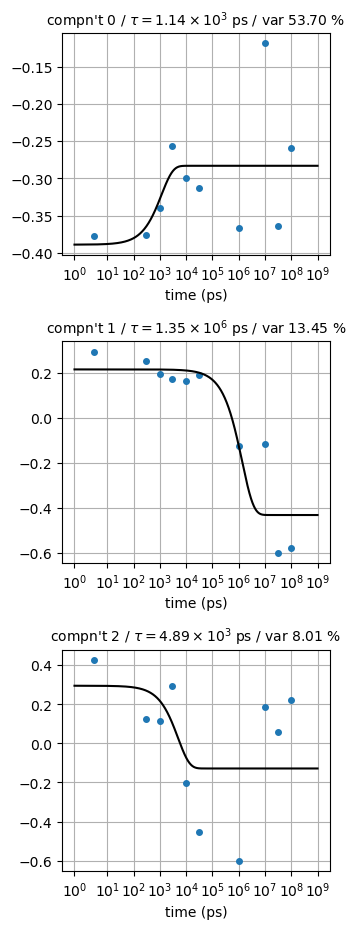

In [10]:
SAVE = True
N_COMPONENTS = 3


plt.figure(figsize=(3.5,12))

for component in range(N_COMPONENTS):

    axL = plt.subplot(N_COMPONENTS+1, 1, component+1)

    x = np.array(tps)[:]
    y = U[:, component]

    expntl = lambda t,a,b,c: a * np.exp(-b*t) + c
    p_opt, _ = curve_fit(expntl,  x,  y,  p0=(0.1, 1e-3, 0.0))
    print(p_opt)

    v_component = Vh[component,:].T

    # ---- plotting

    axL.plot(x, y, 'o', markersize=4)
    x_fine = np.logspace(0,9,1000)
    axL.plot(x_fine, expntl(x_fine, *p_opt), 'k')

    plt.title(
        r"compn't %d / $\tau = %s$ ps / var %.2f %%" % (component, latex_float(1.0 / p_opt[1]), explained_variance[component]),
        font={'size' : 10}
    )
    #plt.suptitle(f'mask = {MASK_NAME}')
    axL.set_xlabel('time (ps)')
    axL.set_xscale('symlog')
    axL.grid()

    if SAVE:
        svd_component_grid = gemmi.FloatGrid(-1.0 * v_component.reshape(MAP_SHAPE))
        masks.grid_to_PL_map(
            svd_component_grid, 
            base_path + f'svd_components/svd_mask{MASK_NAME}_comp{component}.ccp4'
        )

plt.tight_layout()
if SAVE:
    plt.savefig(base_path + 'figures/svd_mask-%s.pdf' % MASK_NAME)
plt.show()